In [1]:
import sys
sys.path.append('../dust3r')
sys.path.append('../gaussian-splatting')
sys.path.append('../src')

In [2]:
from dust3r.inference import inference, load_model
from dust3r.utils.image import load_images
from dust3r.utils.device import to_numpy
from dust3r.image_pairs import make_pairs
from dust3r.cloud_opt import global_aligner, GlobalAlignerMode

import torch
import numpy as np
import matplotlib.pyplot as plt

try:
    import lovely_tensors as lt
except:
    ! pip install --upgrade lovely-tensors
    import lovely_tensors as lt
    
lt.monkey_patch()

In [3]:
model_path = "../dust3r/checkpoints/DUSt3R_ViTLarge_BaseDecoder_512_dpt.pth"
device = 'cuda:0'
batch_size = 1
schedule = 'cosine'
lr = 0.01
niter = 300
scenegraph_type = "complete"
winsize = 1
refid = 0
norm_scene = False
mask_images = True # mask images by confidence threshold for 3DGS

if scenegraph_type == "swin":
    scenegraph_type = scenegraph_type + "-" + str(winsize)
elif scenegraph_type == "oneref":
    scenegraph_type = scenegraph_type + "-" + str(refid)

In [4]:
from pathlib import Path
Path.ls = lambda x: list(x.iterdir())

image_dir = Path('../data/images/turtle_imgs/')

image_files = [str(x) for x in image_dir.ls() if x.suffix in ['.png', '.jpg']]
image_files = sorted(image_files, key=lambda x: int(x.split('/')[-1].split('.')[0]))

In [5]:
model = load_model(model_path, device)
images = load_images(image_files, size=512)
pairs = make_pairs(images, scene_graph='complete', prefilter=None, symmetrize=True)
output = inference(pairs, model, device, batch_size=batch_size)

... loading model from ../dust3r/checkpoints/DUSt3R_ViTLarge_BaseDecoder_512_dpt.pth


/app/notebooks/../dust3r/dust3r/inference.py:17: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt = torch.load(model_path, map_location='cpu')


instantiating : AsymmetricCroCo3DStereo(enc_depth=24, dec_depth=12, enc_embed_dim=1024, dec_embed_dim=768, enc_num_heads=16, dec_num_heads=12, pos_embed='RoPE100', patch_embed_cls='PatchEmbedDust3R', img_size=(512, 512), head_type='dpt', output_mode='pts3d', depth_mode=('exp', -inf, inf), conf_mode=('exp', 1, inf), landscape_only=False)
<All keys matched successfully>
>> Loading a list of 3 images
 - adding ../data/images/turtle_imgs/1.jpg with resolution 964x1280 --> 384x512
 - adding ../data/images/turtle_imgs/2.jpg with resolution 964x1280 --> 384x512
 - adding ../data/images/turtle_imgs/3.jpg with resolution 964x1280 --> 384x512
 (Found 3 images)
>> Inference with model on 6 image pairs


  0%|                                                                                                                                                                              | 0/6 [00:00<?, ?it/s]/app/notebooks/../dust3r/dust3r/inference.py:59: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=bool(use_amp)):
/app/notebooks/../dust3r/dust3r/model.py:161: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=False):
/app/notebooks/../dust3r/dust3r/inference.py:63: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=False):
100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████

In [6]:
scene = global_aligner(output, device=device, mode=GlobalAlignerMode.PointCloudOptimizer)
loss = scene.compute_global_alignment(init="mst", niter=niter, schedule=schedule, lr=lr)

 init edge (1*,0*) score=np.float64(20.44795036315918)
 init edge (1,2*) score=np.float64(16.78103256225586)
 init loss = 0.00819389522075653


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [00:05<00:00, 53.41it/s, lr=1.27413e-06 loss=0.00338764]


In [7]:
from colmap_dataset_utils import inv

intrinsics = scene.get_intrinsics().detach().cpu().numpy()
cam2world = scene.get_im_poses().detach().cpu().numpy()
world2cam = inv(cam2world) #
principal_points = scene.get_principal_points().detach().cpu().numpy()
focals = scene.get_focals().detach().cpu().numpy()
imgs = np.array(scene.imgs)
pts3d = [i.detach() for i in scene.get_pts3d()]
depth_maps = [i.detach() for i in scene.get_depthmaps()]

min_conf_thr = 20
scene.min_conf_thr = float(scene.conf_trf(torch.tensor(min_conf_thr)))
masks = to_numpy(scene.get_masks())

In [8]:
from colmap_dataset_utils import normalize_scene
from copy import deepcopy

pts_norm, c2w_norm = normalize_scene(deepcopy(pts3d), deepcopy(masks), deepcopy(cam2world))
if norm_scene:
    pts3d = pts_norm
    world2cam = inv(np.array(c2w_norm))

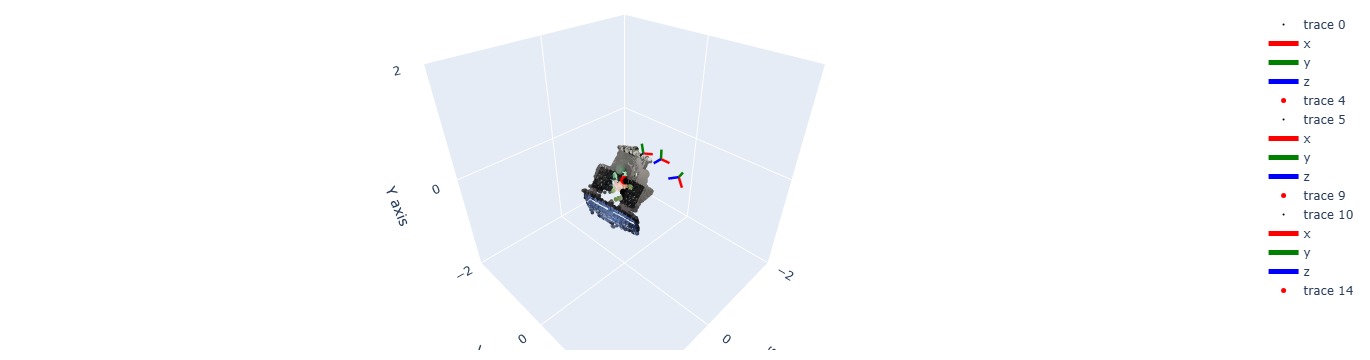

In [12]:
from visualization import visualize_pcd, visualize_cameras
fig = None

num_to_show = 10_000
num_of_valid = sum([m.sum() for m in masks])
skip = num_of_valid // num_to_show

for p, i, m, c2w in zip(pts_norm, imgs, masks, c2w_norm):
    fig = visualize_pcd(p[m].cpu().numpy(), i[m], skip=skip, show=False, size=2, fig=fig)
    R, T = np.transpose(c2w[None, :3, :3], (0, 2, 1)), c2w[None, :, 3]
    fig = visualize_cameras(R, T, fig=fig, show=False, radius=2, size=0.2)
    
fig

# Construct colmap dataset

After convertion such data sctructure should appear

```
│   │   │   ├── images
│   │   │   ├── masks
│   │   │   ├── sparse/0
|   |   |   |    |------cameras.bin
|   |   |   |    |------images.bin
|   |   |   |    |------points3D.bin
|   |   |   |    |------points3D.ply
```

In [10]:
save_dir = Path('../data/scenes/turtle')
save_dir.mkdir(exist_ok=True, parents=True)

In [11]:
from colmap_dataset_utils import (
    init_filestructure,
    save_images_masks,
    save_cameras,
    save_imagestxt,
    save_pointcloud_with_normals
)

save_path, images_path, masks_path, sparse_path = init_filestructure(save_dir)
save_images_masks(imgs, masks, images_path, masks_path, mask_images)
save_cameras(focals, principal_points, sparse_path, imgs_shape=imgs.shape)
save_imagestxt(world2cam, sparse_path)
# save_pointcloud(imgs, pts3d, masks, sparse_path)
save_pointcloud_with_normals(imgs, pts3d, masks, sparse_path)